In [1]:
import pandas as pd
import re

from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus  import stopwords
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

/var/folders/8g/tf9vw4pd7fq5p7_swsslw8jc0000gn/T/ipykernel_71384/2835787529.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/prabinapokharel/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/prabinapokharel/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/prabinapokharel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Data Cleaning

In [2]:
df = pd.read_csv("data/data_queue_final.csv", index_col=False)
df = df.drop(df.columns[0], axis=1)
df

,question,student_answer,correct
0,What is the role of a prototype program in pro...,High risk problems are address in the prototyp...,0
1,What is the role of a prototype program in pro...,To simulate portions of the desired final prod...,0
2,What is the role of a prototype program in pro...,A prototype program simulates the behaviors of...,0
3,What is the role of a prototype program in pro...,Defined in the Specification phase a prototype...,0
4,What is the role of a prototype program in pro...,It is used to let the users have a first idea ...,0
...,...,...,...
2292,What is a queue?,A first in first out data structure,1
2293,What is a queue?,"A queue is a stack of sequenced tasks, underta...",0
2294,What is a queue?,A queue in computer science is the 81st or 113...,0
2295,What is a queue?,a queue is a abstract data type with a private...,1


In [3]:
responses_OG = df['student_answer'].tolist()

In [4]:
correct_responses_OG = [df.loc[i, 'student_answer'] for i in df.index if df.loc[i, 'correct'] == 1]
incorrect_responses_OG = [df.loc[i, 'student_answer'] for i in df.index if df.loc[i, 'correct'] == 0]
len(incorrect_responses_OG)

2240

In [5]:
query_question = "What is a queue?"
query_response_OG = "A queue is a data structure that follows FIFO principle, meaning that the first element added to the queue will be the first one to be removed."

In [6]:
def cleaning(text):
    lowered = text.lower() 
    removed = re.sub(r'[^a-z]', ' ', lowered)  
    tokens = nltk.word_tokenize(removed)
    lemmatizer = WordNetLemmatizer()
    cleaned_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stopwords.words('english')]
    cleaned_text = ' '.join(cleaned_tokens)
    return cleaned_text

In [7]:
df['student_answer'] = df['student_answer'].apply(cleaning)

responses = df['student_answer'].tolist()

correct_responses = [df.loc[i, 'student_answer'] for i in df.index if df.loc[i, 'correct'] == 1]
incorrect_responses = [df.loc[i, 'student_answer'] for i in df.index if df.loc[i, 'correct'] == 0]

In [8]:
query_response = cleaning(query_response_OG)

In [9]:
df['correct'].value_counts()

correct
0    2240
1      57
Name: count, dtype: int64

In [10]:
class_0 = df[df['correct'] == 0]
class_1 = df[df['correct'] == 1]

class_0_undersampled = class_0.sample(n=len(class_1), random_state=42)
new_df = pd.concat([class_0_undersampled, class_1])
df = new_df.sample(frac=1, random_state=42).reset_index(drop=True)


In [11]:
df['correct'].value_counts()

correct
1    57
0    57
Name: count, dtype: int64

# Model

## Only tf-idf and Random Forest

In [12]:
pipeline = Pipeline([
    
    ('tfidf', TfidfVectorizer(preprocessor=cleaning)),
    ('classifier', RandomForestClassifier())
])

X_train, X_test, y_train, y_test = train_test_split(df['student_answer'], df['correct'], test_size=0.2)

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

f1_score = f1_score(y_test, y_pred)
print("F1 score:", f1_score)


F1 score: 0.9166666666666666


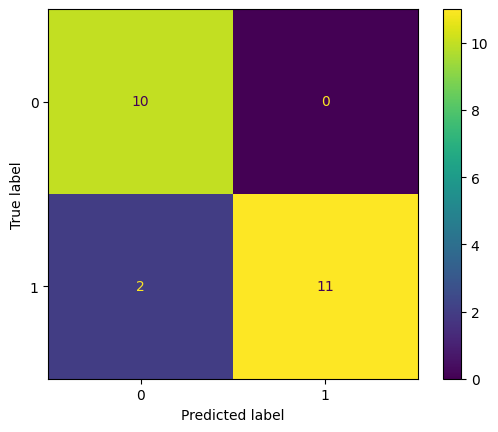

In [13]:
conf = confusion_matrix(y_test, y_pred)
dis = ConfusionMatrixDisplay(confusion_matrix=conf)
dis.plot()


# Add thresholding

In [14]:
y_proba = pipeline.predict_proba(X_test)[:, 1]

threshold = 0.5

y_pred_threshold = (y_proba >= threshold).astype(int)

accuracy_threshold = accuracy_score(y_test, y_pred_threshold)
precision_threshold = precision_score(y_test, y_pred_threshold)
recall_threshold = recall_score(y_test, y_pred_threshold)
f1_threshold = f1_score(y_test, y_pred_threshold)

print("Accuracy:", accuracy_threshold)
print("Precision:", precision_threshold)
print("Recall:", recall_threshold)
print("F1 Score:", f1_threshold)

Accuracy: 0.9130434782608695
Precision: 1.0
Recall: 0.8461538461538461
F1 Score: 0.9166666666666666


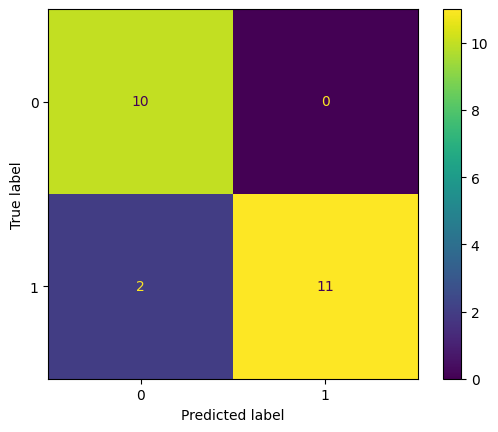

In [15]:
conf = confusion_matrix(y_test, y_pred)
dis = ConfusionMatrixDisplay(confusion_matrix=conf)
dis.plot()

In [16]:
# Predict probabilities instead of class labels
y_probabilities = pipeline.predict_proba(X_test)[:, 1]

thresholds = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7]

for threshold in thresholds:
    y_pred_threshold = (y_probabilities > threshold).astype(int)
    precision = precision_score(y_test, y_pred_threshold)
    recall = recall_score(y_test, y_pred_threshold)
    f1 = f1_score(y_test, y_pred_threshold)
    print(f"Threshold: {threshold}, Precision: {precision}, Recall: {recall}, F1 Score: {f1}")


Threshold: 0.2, Precision: 0.8125, Recall: 1.0, F1 Score: 0.896551724137931
Threshold: 0.3, Precision: 1.0, Recall: 0.9230769230769231, F1 Score: 0.9600000000000001
Threshold: 0.4, Precision: 1.0, Recall: 0.9230769230769231, F1 Score: 0.9600000000000001
Threshold: 0.5, Precision: 1.0, Recall: 0.8461538461538461, F1 Score: 0.9166666666666666
Threshold: 0.6, Precision: 1.0, Recall: 0.8461538461538461, F1 Score: 0.9166666666666666
Threshold: 0.7, Precision: 1.0, Recall: 0.8461538461538461, F1 Score: 0.9166666666666666


## Add n-gram

In [17]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(preprocessor=cleaning, ngram_range=(1, 2))),
    ('classifier', RandomForestClassifier())
])

X_train, X_test, y_train, y_test = train_test_split(df['student_answer'], df['correct'], test_size=0.2, random_state=42)

pipeline.fit(X_train, y_train)

y_proba = pipeline.predict_proba(X_test)[:, 1]

threshold = 0.3

y_pred_threshold = (y_proba >= threshold).astype(int)

accuracy_threshold = accuracy_score(y_test, y_pred_threshold)
precision_threshold = precision_score(y_test, y_pred_threshold)
recall_threshold = recall_score(y_test, y_pred_threshold)
f1_threshold = f1_score(y_test, y_pred_threshold)

print("Accuracy (with adjusted threshold):", accuracy_threshold)
print("Precision (with adjusted threshold):", precision_threshold)
print("Recall (with adjusted threshold):", recall_threshold)
print("F1 Score (with adjusted threshold):", f1_threshold)

Accuracy (with adjusted threshold): 0.9130434782608695
Precision (with adjusted threshold): 0.8461538461538461
Recall (with adjusted threshold): 1.0
F1 Score (with adjusted threshold): 0.9166666666666666


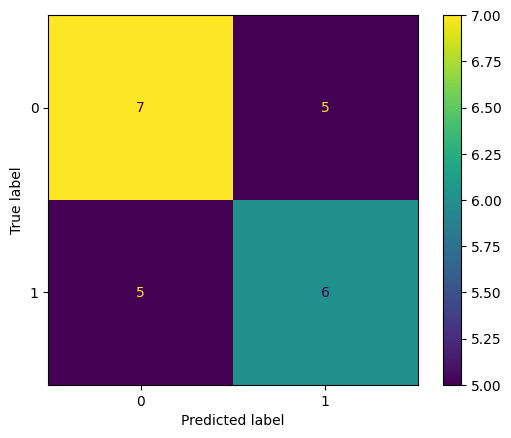

In [18]:
conf = confusion_matrix(y_test, y_pred)

dis = ConfusionMatrixDisplay(confusion_matrix=conf)
dis.plot()
